# Digit Recognizer - MNIST
##### https://www.kaggle.com/competitions/digit-recognizer

### Imports


In [128]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

### Load Data

In [129]:
# In each row, first column contains a label (digit). The remainder 784 columns (28px x 28px image) contain pixel values of 0-255.
mnist_data = pd.read_csv("data/train.csv")
mnist_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Transform Data

In [130]:
# Shuffle data
mnist_data = mnist_data.sample(frac=1, axis=0)
mnist_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
10330,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16511,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23550,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27193,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36723,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16801,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20505,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9818,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
33393,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
# Transpose the data so that the first row will be equal to all the labels and the remainder of rows in each column will be the corresponding pixel value
transposed_mnist_data = mnist_data.T
transposed_mnist_data.head()

,10330,16511,23550,27193,36723,10388,18285,41098,28705,16494,...,25712,21278,29507,24407,29911,16801,20505,9818,33393,20667
label,5,9,7,7,8,6,7,9,4,4,...,6,1,7,3,9,5,3,8,4,3
pixel0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pixel1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pixel2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pixel3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [132]:
# Create NumPy array from Pandas dataframe
mnist_data_arr = transposed_mnist_data.values

In [133]:
mnist_data_arr

array([[5, 9, 7, ..., 8, 4, 3],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [134]:
Y = mnist_data_arr[0, 1000:]
Y

array([7, 7, 8, ..., 8, 4, 3])

In [135]:
Y_test = mnist_data_arr[0, :1000]
Y_test

array([5, 9, 7, 7, 8, 6, 7, 9, 4, 4, 5, 9, 5, 8, 3, 9, 8, 9, 8, 8, 4, 3,
       1, 2, 2, 9, 9, 1, 2, 7, 5, 2, 8, 3, 1, 6, 9, 6, 7, 0, 3, 2, 2, 4,
       8, 4, 0, 1, 5, 0, 0, 1, 9, 5, 4, 1, 6, 1, 3, 6, 4, 7, 5, 4, 3, 0,
       7, 3, 8, 2, 0, 5, 5, 4, 5, 1, 3, 8, 3, 4, 3, 9, 0, 4, 2, 8, 1, 6,
       7, 2, 7, 7, 5, 0, 0, 7, 8, 7, 7, 3, 2, 6, 9, 9, 7, 1, 5, 7, 1, 0,
       8, 9, 9, 9, 0, 9, 9, 8, 0, 8, 3, 9, 2, 0, 9, 0, 0, 2, 7, 2, 3, 0,
       8, 2, 3, 0, 5, 7, 6, 1, 1, 7, 3, 0, 2, 6, 6, 3, 2, 9, 1, 9, 7, 4,
       8, 2, 5, 8, 4, 8, 4, 7, 2, 9, 1, 5, 7, 0, 2, 9, 7, 8, 2, 6, 9, 7,
       5, 1, 1, 4, 3, 3, 7, 1, 4, 6, 5, 7, 7, 3, 4, 2, 9, 8, 3, 9, 7, 8,
       0, 4, 5, 2, 3, 2, 1, 5, 6, 5, 6, 3, 2, 5, 5, 1, 2, 2, 7, 2, 4, 3,
       2, 7, 0, 9, 3, 8, 7, 3, 9, 6, 1, 8, 5, 0, 1, 4, 3, 7, 6, 3, 4, 3,
       4, 1, 1, 4, 0, 9, 8, 4, 9, 7, 5, 0, 8, 9, 7, 4, 8, 2, 1, 8, 1, 6,
       3, 0, 8, 8, 5, 7, 9, 6, 0, 1, 6, 7, 2, 3, 9, 2, 7, 9, 9, 2, 1, 7,
       1, 1, 2, 1, 2, 6, 5, 5, 5, 7, 5, 6, 3, 0, 5,

In [136]:
# Get all rows except the first one (because it contains labels), each column is one example
# Since the pixelvalues are 0-255 we divide them by 255 to get values between 0 and 1 as activations of the input layer
# Each row is one example
X = (mnist_data_arr[1:, 1000:] / 255.0)
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [137]:
X_test = (mnist_data_arr[1:, :1000] / 255.0)
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [138]:
# Transform a label so that 3 is represented by [0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0] instead of just 3
def one_hot(y):
    desired_output = np.zeros((10, 1))
    desired_output[y] = 1.0
    return desired_output

In [139]:
# Transform our labels so that 3 is represented by [0, 0, 0, 1.0, 0, 0, 0, 0, 0, 0] instead of just 3
# Each column is one example
one_hot_Y = np.array([one_hot(y) for y in Y]).T.reshape((10, 41000))
one_hot_Y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Setup of weights and biases
##### This will depend on the # of layers and the # of neurons in each of them.
##### We will have 1 hidden layer with 30 neurons and 1 output layer with 10 neurons

In [140]:
W1 = np.random.rand(30, 784) - 0.5
b1 = np.random.rand(30, 1)   - 0.5
W2 = np.random.rand(10, 30)  - 0.5
b2 = np.random.rand(10, 1)   - 0.5

### Helper functions


In [141]:
def sigmoid(Z):
    # Sigmoid function, applied elementwise if z is a matrix
    return 1.0 / (1.0 + np.exp(-Z))

def sigmoid_derivative(Z):
    # sigmoid(z) * (1 - sigmoid(z))
    # sigmoig(z) = activation so we can do it like below
    return sigmoid(Z) * (1.0 - sigmoid(Z))


In [142]:
def cost(A, Y):
    return np.power((A - Y) / 2, 2)

def cost_derivative(A, Y):
    return A - Y

In [143]:
def calculate_accuracy(output, expected):
    max_indices = np.argmax(A2, axis=0)
    print(np.sum(max_indices == expected) / len(expected))

## Stochastic Gradient Descent

In [159]:
epochs = 1000
sample_size = 100
learning_rate = 0.5
for epoch in range(epochs):
    random_int = np.random.randint(sample_size, 42001)

    X_sample = X[:, random_int - sample_size : random_int]
    one_hot_Y_sample = one_hot_Y[:, random_int - sample_size : random_int]

    # Feedforward
    # Calculate activations in the first and second layer.
    # A1 & A2 contain activations in respective layers for each example
    Z1 = np.dot(W1, X_sample) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    # calculate_accuracy(A2, inputs_labels)
    error_A2 = cost_derivative(A2, one_hot_Y_sample) * sigmoid_derivative(Z2)
    error_A1 = np.dot(W2.T, error_A2)

    # Gradient descent
    delta_W2 = np.dot(error_A2, A1.T)        / sample_size
    delta_W1 = np.dot(error_A1, X_sample.T)  / sample_size
    delta_b2 = np.sum(error_A2)              / sample_size
    delta_b1 = np.sum(error_A1)              / sample_size

    # Update weights and biases
    W1 = W1 - delta_W1 * learning_rate
    W2 = W2 - delta_W2 * learning_rate
    b1 = b1 - delta_b1 * learning_rate
    b2 = b2 - delta_b2 * learning_rate

    # Feedforward => testing
    Z1 = np.dot(W1, X_test) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    if epoch % 100 == 0:
        calculate_accuracy(A2, Y_test)

0.841
0.843
0.835
0.838
0.834
0.83
0.825
0.834
0.841
0.83


In [162]:
def test_weights_and_biases(idx):
    current_image = X[:, idx, None]

    Z1 = np.dot(W1, current_image) + b1
    A1 = sigmoid(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    label = Y[idx]

    print("Prediction: ", np.argmax(A2))
    print("Label:      ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  6
Label:       6


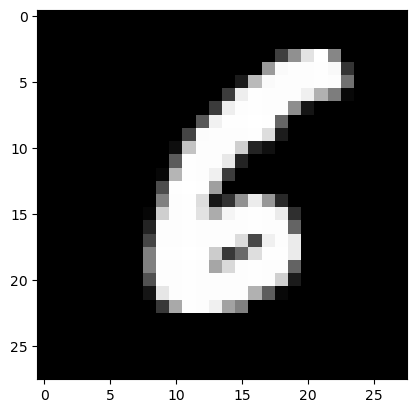

In [163]:
test_weights_and_biases(40121)